# Imports and Setup

This notebook contains code for running a model inversion attack against a trained PyTorch model. It can be tested by the user by uploading a PyTorch model and running the notebook in Google Colab. 

By default the notebook is set up to attack trained Resnet18 models, as we used for evaluation. This can be altered by changing parameters pertaining to model and input shape.

In [5]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable
from scipy import ndimage
from resnet_1 import ResNet18
import copy
import random

torch.set_printoptions(precision=3)
cuda = True if torch.cuda.is_available() else False

In [6]:
def normalize(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.detach().numpy()
    trans = np.transpose(npimg, (1,2,0))
    return np.squeeze(trans)

In [7]:
def imshow(img):
    temp = normalize(img)
    plt.imshow(temp, vmin=0, vmax=1, cmap='Greys_r')
    plt.show()

In [8]:
def imsave(img):
    temp = normalize(img)
    plt.imshow(temp, vmin=0, vmax=1, cmap='Greys_r')
    plt.axis("off")
    plt.savefig("inversion.png", dpi=300)
    plt.show()

In [9]:
# Transform image to tensor and normalize features from [0,255] to [0,1]
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5,),(0.5,)),
                                ])

# Model Inversion

The model inversion attack beings with a random noise vector and iteratively takes steps
in the direction of decreased classification loss of the target class.

model = the pytorch model to attack

target = an integer representing the target class

learning_rate = floating-point learning rate

num_iters = how many iterations to run the attack

examples = how many inversion attacks to run

show = if True, show each inversion attack as it's generated

div = the value to divide the initial noise vector by: noise = noise/div

shape  = the shape of the example

In [10]:
def invert(model, x, y, num_iters=5000, learning_rate=1, show=False, refine=True, t1 = -1/6, t2 = -1):

  model.eval()
  nx = Variable(x.data, requires_grad=True)
  loss = 10000000

  for i in range(num_iters + 1):
    if i % 100 == 0:
      print("\rIteration: {}\tLoss: {}".format(i, loss), end="")
    model.zero_grad()
    pred = model(nx)
    loss = criterion(pred, y)
    loss.backward()
    nx = nx - learning_rate*nx.grad
    if refine:
      if i % 500 == 0 and i > 0 and i < num_iters:
        nx = ndimage.median_filter(nx.detach(), size=2)
        blur = ndimage.gaussian_filter(nx, sigma=2, truncate=t1)
        filter_blur = ndimage.gaussian_filter(blur, sigma=1, truncate=t2)
        nx = blur + 80 * (blur - filter_blur)
        nx = Variable(torch.from_numpy(nx), requires_grad=True)
      else:
        nx = Variable(nx.data, requires_grad=True)
    else:
      nx = Variable(nx.data, requires_grad=True)
  
  return nx[0]

In [11]:
def generate(model, target, learning_rate=1, num_iters=8000, examples=1, show = True,
             div=256, shape=(1,1,28,28)):
  images = []
  for i in range(examples):

    print("\nInversion {}/{}".format(i+1, examples))
    noise = torch.rand(shape, dtype=torch.float, requires_grad=False)
    noise /= div
    noise -= 1
    noise.requires_grad=True
    targetval = torch.tensor([target])
    image = invert(model, noise, targetval, show=False, learning_rate=learning_rate, num_iters=num_iters,
                    refine=True)
    images.append(image)
    if show:
      images = torch.stack(images)
      imshow(torchvision.utils.make_grid(images, nrow=4))
  return images

# Model Loading

To use your own model, replace this section with any torch model

In [12]:
# load resnet 18 and change to fit problem dimensionality
criterion = F.nll_loss
model = models.resnet18()
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)
model.fc = nn.Sequential(nn.Linear(512, 10), nn.LogSoftmax(dim=1))

In [13]:
import torch
from common.resnet_for_mnist import ResNet18
# path = F"retraining-epoch-15.pt"
path = F"resnet18_mnist_normal_train_20.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())
print(device)
checkpoint = torch.load(path)
model = ResNet18().to(device)
model.load_state_dict(checkpoint)
print('finished')

1.7.1+cu110
11.0
8004
cuda
cuda
finished


# Inversion Attack


Inversion 1/12
Iteration: 1000	Loss: -68.15086364746094
Inversion 2/12
Iteration: 1000	Loss: -65.90038299560547
Inversion 3/12
Iteration: 1000	Loss: -68.35058593757664
Inversion 4/12
Iteration: 1000	Loss: -66.17675018310547
Inversion 5/12
Iteration: 1000	Loss: -69.70175933837895
Inversion 6/12
Iteration: 1000	Loss: -65.63534545898438
Inversion 7/12
Iteration: 1000	Loss: -67.75479888916016
Inversion 8/12
Iteration: 1000	Loss: -66.44751739501953
Inversion 9/12
Iteration: 1000	Loss: -64.14633178710938
Inversion 10/12
Iteration: 1000	Loss: -63.97456359863281
Inversion 11/12
Iteration: 1000	Loss: -69.7165298461914
Inversion 12/12
Iteration: 1000	Loss: -67.89962005615234

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


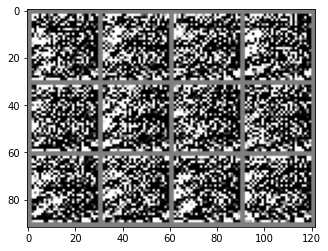

In [14]:
inversion = generate(model, target=3, num_iters=1000, examples=12, div=128)
images = torch.stack(inversion)
imshow(torchvision.utils.make_grid(images, nrow=4))